# My Extended Spotify Streaming History Analysis

In [1]:
import pandas as pd
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
json_dir = "Spotify Extended Streaming History/"

all_records = []

for file in os.listdir(json_dir):
    if file.endswith(".json"):
        file_path = os.path.join(json_dir, file)
        
        with open(file_path, 'r') as f:
            data = json.load(f)
            
            if isinstance(data, list):
                all_records.extend(data)
            else:
                all_records.append(data)

# Convert to normalized df
df = pd.json_normalize(all_records)

df.to_csv("spotify_data_normalized.csv", index=False)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838324 entries, 0 to 838323
Data columns (total 19 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ts                                 838324 non-null  object 
 1   platform                           838324 non-null  object 
 2   ms_played                          838324 non-null  int64  
 3   conn_country                       838324 non-null  object 
 4   ip_addr                            838324 non-null  object 
 5   master_metadata_track_name         838121 non-null  object 
 6   master_metadata_album_artist_name  838121 non-null  object 
 7   master_metadata_album_album_name   838121 non-null  object 
 8   spotify_track_uri                  838121 non-null  object 
 9   episode_name                       203 non-null     object 
 10  episode_show_name                  201 non-null     object 
 11  spotify_episode_uri                203 

## Data Cleaning

In [3]:
# Drop podcast info and ip address
df = df.drop(columns=['episode_name', 'episode_show_name', 'spotify_episode_uri', 'ip_addr', 'spotify_track_uri'])
df['ts'] = pd.to_datetime(df['ts'])
df['date'] = df['ts'].dt.date
df['hour'] = df['ts'].dt.hour
df['day'] = df['ts'].dt.day
df['month'] = df['ts'].dt.month
df['year'] = df['ts'].dt.year
df['weekday'] = pd.to_datetime(df['ts']).dt.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: x >= 5)  # True for Saturday/Sunday
df_cleaned = df[df['year'] >= 2019]


# Drop rows where no track_name/album_name/artist_name
df_cleaned = df_cleaned.dropna(subset=[
    'master_metadata_track_name', 
    'master_metadata_album_artist_name', 
    'master_metadata_album_album_name'
])

df_cleaned.head(5)

,ts,platform,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,reason_start,reason_end,shuffle,...,offline,offline_timestamp,incognito_mode,date,hour,day,month,year,weekday,is_weekend
0,2024-10-11 20:17:56+00:00,ios,1137,GB,We No Speak Americano (Edit),Yolanda Be Cool,We No Speak Americano,fwdbtn,fwdbtn,True,...,False,1.728678e+09,False,2024-10-11,20,11,10,2024,4,False
1,2024-10-11 20:17:59+00:00,ios,2647,GB,Paint The Town Red,Doja Cat,Scarlet,fwdbtn,fwdbtn,True,...,False,1.728678e+09,False,2024-10-11,20,11,10,2024,4,False
2,2024-10-11 20:18:00+00:00,ios,952,GB,Riri,Young Miko,TRAP KITTY,fwdbtn,fwdbtn,True,...,False,1.728678e+09,False,2024-10-11,20,11,10,2024,4,False
3,2024-10-11 20:18:02+00:00,ios,1857,GB,Gasolina,Daddy Yankee,Barrio Fino (Bonus Track Version),fwdbtn,fwdbtn,True,...,False,1.728678e+09,False,2024-10-11,20,11,10,2024,4,False
4,2024-10-11 20:18:04+00:00,ios,2275,GB,World Hold On - FISHER Rework,Bob Sinclar,World Hold On,fwdbtn,fwdbtn,True,...,False,1.728678e+09,False,2024-10-11,20,11,10,2024,4,False


In [4]:
for col in df_cleaned.columns:
    print(f"{col}: {df_cleaned[col].nunique()} unique values")

ts: 457837 unique values
platform: 43 unique values
ms_played: 58269 unique values
conn_country: 18 unique values
master_metadata_track_name: 18750 unique values
master_metadata_album_artist_name: 6959 unique values
master_metadata_album_album_name: 14642 unique values
reason_start: 10 unique values
reason_end: 10 unique values
shuffle: 2 unique values
skipped: 2 unique values
offline: 2 unique values
offline_timestamp: 176658 unique values
incognito_mode: 2 unique values
date: 2000 unique values
hour: 24 unique values
day: 31 unique values
month: 12 unique values
year: 7 unique values
weekday: 7 unique values
is_weekend: 2 unique values


## Observations & Insights 🕵️

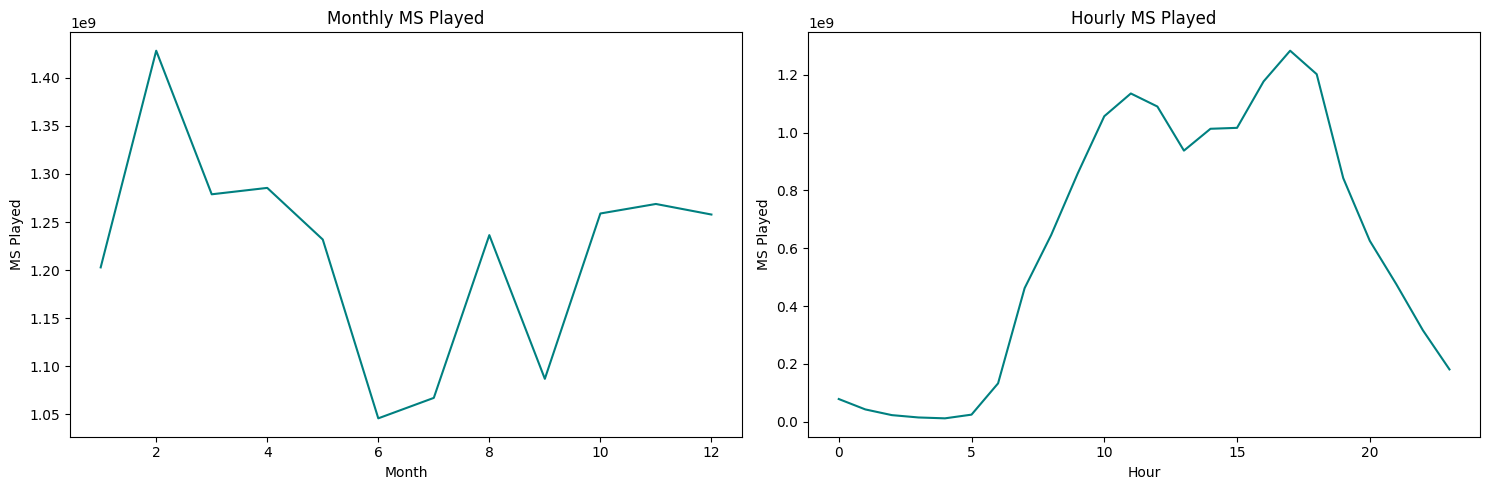

In [123]:
monthly_trends = df_cleaned.groupby('month')['ms_played'].sum().reset_index()
hourly_trends = df_cleaned.groupby('hour')['ms_played'].sum().reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot daily ms_played
sns.lineplot(data=monthly_trends, x="month", y="ms_played", color='teal', ax=axes[0])
axes[0].set_title('Monthly MS Played')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('MS Played')

sns.lineplot(data=hourly_trends, x="hour", y="ms_played", color='teal', ax=axes[1])
axes[1].set_title('Hourly MS Played')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('MS Played')

# Show plot
plt.tight_layout()
plt.show()

### Insights:
Daily
- The peak in February (including other 🧊 months) could be due to winter months when indoor activities are common/less frequent socializing
- The dip in the mid-year might align with summer activities when I spend more time outdoors or on vacations, reducing streaming time

Hourly
- Sharp increase from early morning hours - commute/getting ready
- Clear lunch break pause 🌮 followed by an extra afternoon boost while I code
- Preference for afternoon listening time 🎶

In [95]:
## Playback Modes
shuffle_stats = df_cleaned['shuffle'].value_counts(normalize=True) * 100
print(f'Shuffle Stats:{shuffle_stats}')

skipped_stats = df_cleaned['skipped'].value_counts(normalize=True) * 100
print(f'Tracks Skipped vs Played: {skipped_stats}')

Shuffle Stats:shuffle
True     94.840731
False     5.159269
Name: proportion, dtype: float64
Tracks Skipped vs Played: skipped
False    77.357795
True     22.642205
Name: proportion, dtype: float64


In [104]:
# Geographical insights
country_stats = df_cleaned['conn_country'].value_counts(normalize=True) * 100
print(country_stats)

conn_country
GB    47.053330
ES    46.870577
RS     2.679625
ME     1.096840
US     0.660004
BR     0.410912
PT     0.373557
HR     0.322515
IT     0.301583
IS     0.120762
ZZ     0.041059
GR     0.022703
AT     0.016424
CO     0.016424
DE     0.006280
NL     0.005797
FR     0.000966
DK     0.000644
Name: proportion, dtype: float64


## Has my taste in artist changed over the years?

<Figure size 1200x800 with 0 Axes>

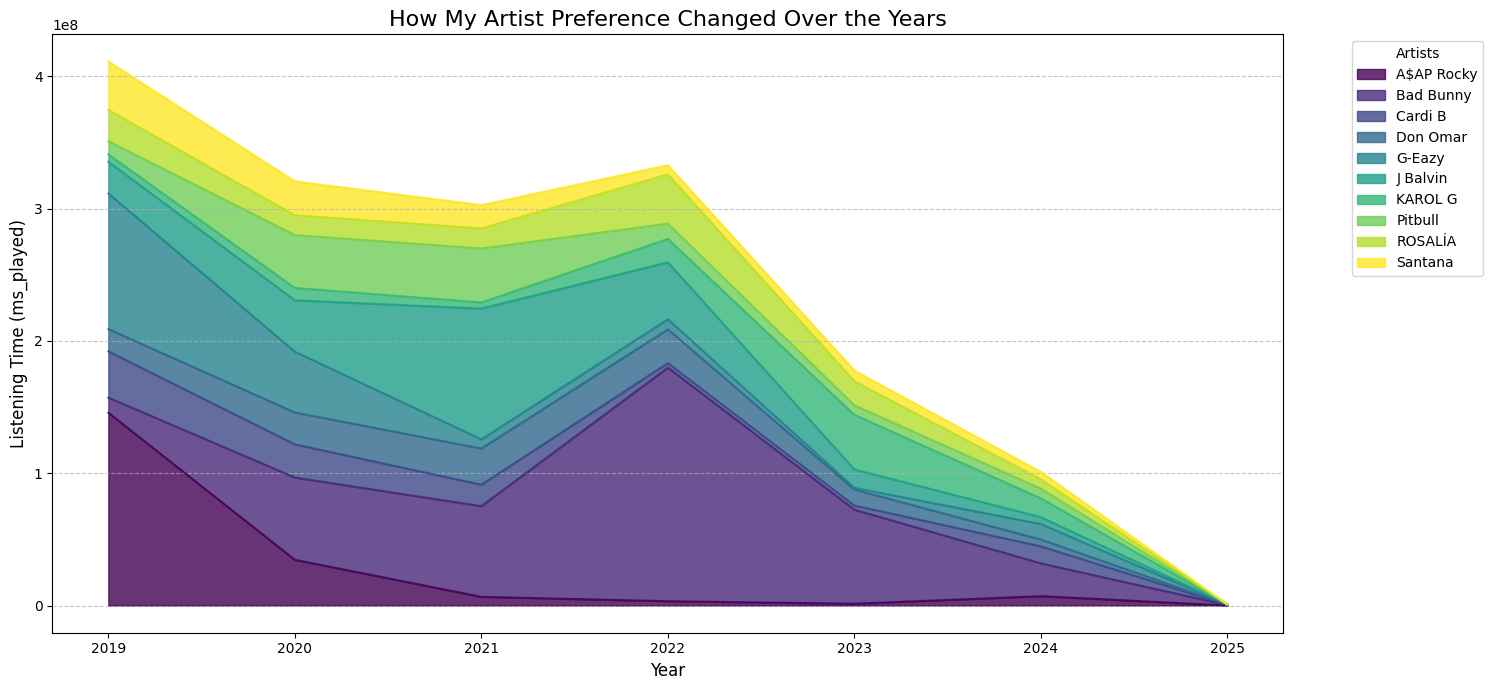

In [124]:
artist_trends = df_cleaned.groupby(['year', 'master_metadata_album_artist_name'])['ms_played'].sum().reset_index()

top_artists = artist_trends.groupby('master_metadata_album_artist_name')['ms_played'].sum().nlargest(10).index
artist_trends_filtered = artist_trends[artist_trends['master_metadata_album_artist_name'].isin(top_artists)]

artist_trends_pivot = artist_trends_filtered.pivot(index='year', columns='master_metadata_album_artist_name', values='ms_played').fillna(0)

# Plot stacked area chart
plt.figure(figsize=(12, 8))
artist_trends_pivot.plot(kind='area', stacked=True, figsize=(15, 7), colormap='viridis', alpha=0.8)

plt.title("How My Artist Preference Changed Over the Years", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Listening Time (ms_played)", fontsize=12)
plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

##### I can confirm I was learning how to play Santana Songs 🎸 on my guitar all of 2019 and Covid ...
##### The Rap Genre's clearly fighting to stay in the competition with reggaeton

## Has my taste in albums changed over the years?

<Figure size 1200x800 with 0 Axes>

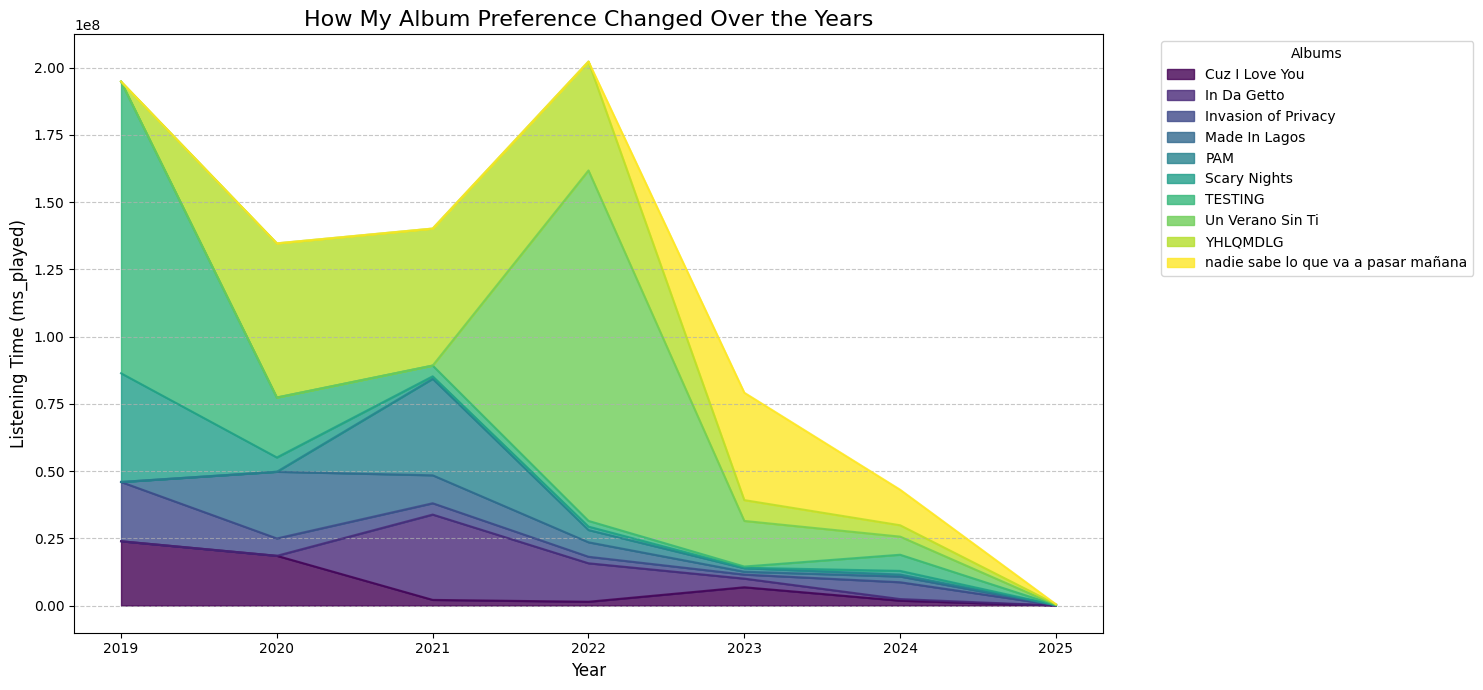

In [126]:
album_trends = df_cleaned.groupby(['year', 'master_metadata_album_album_name'])['ms_played'].sum().reset_index()

top_albums = album_trends.groupby('master_metadata_album_album_name')['ms_played'].sum().nlargest(10).index
album_trends_filtered = album_trends[album_trends['master_metadata_album_album_name'].isin(top_albums)]

album_trends_pivot = album_trends_filtered.pivot(index='year', columns='master_metadata_album_album_name', values='ms_played').fillna(0)

# Plot stacked area chart
plt.figure(figsize=(12, 8))
album_trends_pivot.plot(kind='area', stacked=True, figsize=(15, 7), colormap='viridis', alpha=0.8)

plt.title("How My Album Preference Changed Over the Years", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Listening Time (ms_played)", fontsize=12)
plt.legend(title="Albums", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

##### Although hispanic artists have dominated my charts there's only 1 spanish album in my top 4!
##### This suggests although spanish songs are my favorite, I'm overall not a big fan of multiple songs within the album
##### We can finally see more variety as Pop, Rap and Afrobeats make an appearance

## Can we dig further to find variety? Perhaps my location impacts my mood 🌎 👀

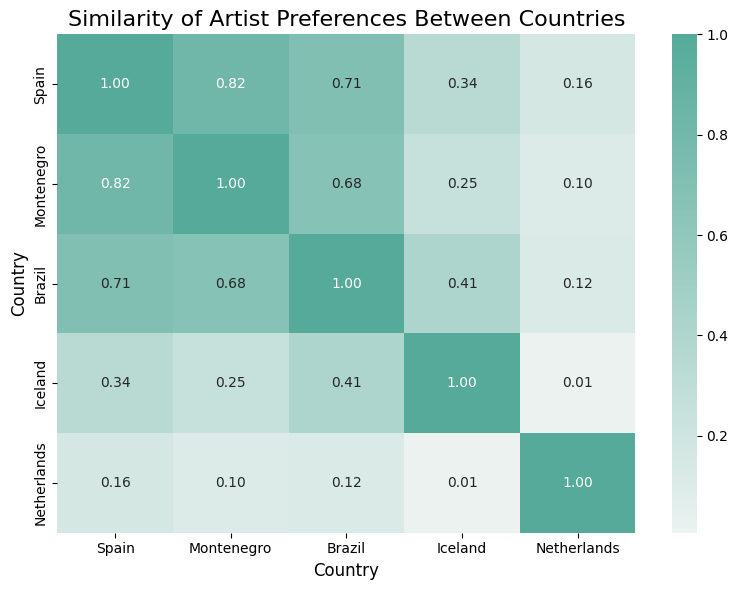

In [22]:
from scipy.spatial.distance import cosine
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

country_name_mapping = {
    "GB": "Great Britain",
    "ES": "Spain",
    "CO": "Colombia",
    "ME": "Montenegro",
    "US": "United States",
    "BR": "Brazil",
    "NL": "Netherlands",
    "AT": "Austria",
    "IS": "Iceland"
}

# Selected mix of "warmer/sunnier and colder" countries for comparison
countries = ["ES", "ME", "BR", "IS", "NL"]

artist_country_dist = df_cleaned.groupby(['conn_country', 'master_metadata_album_artist_name']).size().unstack(fill_value=0)
artist_country_dist_normalized = artist_country_dist.div(artist_country_dist.sum(axis=1), axis=0)

similarity_matrix = pd.DataFrame(index=countries, columns=countries)

for country1 in countries:
    for country2 in countries:
        similarity_matrix.loc[country1, country2] = 1 - cosine(
            artist_country_dist_normalized.loc[country1],
            artist_country_dist_normalized.loc[country2]
        )

similarity_matrix.index = [country_name_mapping[c] for c in similarity_matrix.index]
similarity_matrix.columns = [country_name_mapping[c] for c in similarity_matrix.columns]

custom_cmap = sns.color_palette("light:#5A9", as_cmap=True)

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix.astype(float), annot=True, cmap=custom_cmap, fmt=".2f")
plt.title("Similarity of Artist Preferences Between Countries", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Country", fontsize=12)
plt.tight_layout()

plt.show()


##### Could this suggest a correlation between weather and album preference ?
##### We would additional information to find out as Iceland was visited during summer but was still "cold"
##### A genre column would have been ideal here and a full dataset on a summer and winter month across multiple countries (to cover both hemispheres)

## Now you know my favorites.. but who are my most disliked from my Top 100 ?

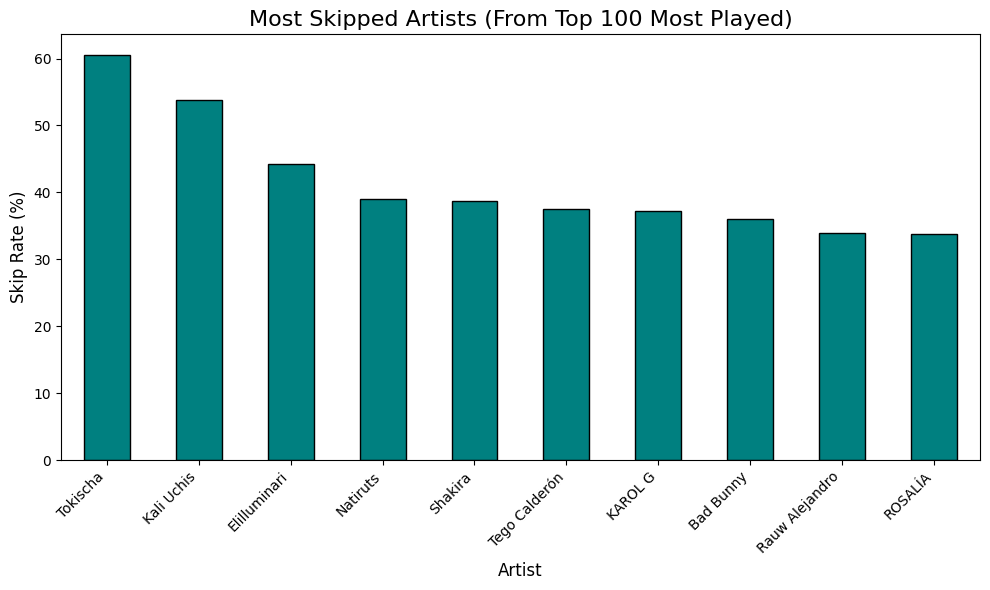

In [122]:
artist_skip_data = df.groupby('master_metadata_album_artist_name').agg(
    total_tracks=('master_metadata_album_artist_name', 'count'),
    total_skipped=('skipped', 'sum'),
    total_played_time=('ms_played', 'sum')
)
top_100_artists = artist_skip_data.sort_values('total_played_time', ascending=False).head(100)

# Calculate skip rate for the top 100 artists
top_100_artists['skip_rate'] = (top_100_artists['total_skipped'] / top_100_artists['total_tracks']) * 100

top_skipped_artists = top_100_artists.sort_values('skip_rate', ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_skipped_artists['skip_rate'].plot(kind='bar', color='teal', edgecolor='black')
plt.title("Most Skipped Artists (From Top 100 Most Played)", fontsize=16)
plt.xlabel("Artist", fontsize=12)
plt.ylabel("Skip Rate (%)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


##### Not Shakira 😭
##### Interestingly, Bad Bunny is both my #3 Artist & my 8th most skipped ! Overindulged 📉?
##### Tokischa is a high energy artist, possibly not always in a high energy mood?

## Overall interesting insights but would need additional data to get a proper deep dive